In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras import datasets, layers, models

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from time import perf_counter
import glob
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns

In [ ]:
image_dir = Path('/content/drive/MyDrive/Augmented_Seed_Data')
# Adjust the glob pattern to match your directory structure.
# For example, if images are directly in subfolders of Seed_Data, use '*/*'
# If there are subfolders within subfolders, adjust accordingly.
# Assuming images are in immediate subfolders of Seed_Data:
filepaths = list(image_dir.glob(r'*/*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [ ]:
# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

In [ ]:
# Show the result
image_df.head(6)

,Filepath,Label
0,/content/drive/MyDrive/Augmented_Seed_Data/Swe...,Sweet_Gourd
1,/content/drive/MyDrive/Augmented_Seed_Data/Mal...,Malabar_Spinach_Seeds
2,/content/drive/MyDrive/Augmented_Seed_Data/Swe...,Sweet_Gourd
3,/content/drive/MyDrive/Augmented_Seed_Data/Swe...,Sweet_Gourd
4,/content/drive/MyDrive/Augmented_Seed_Data/Str...,String_Beans
5,/content/drive/MyDrive/Augmented_Seed_Data/Swe...,Sweet_Gourd


**Visualization**

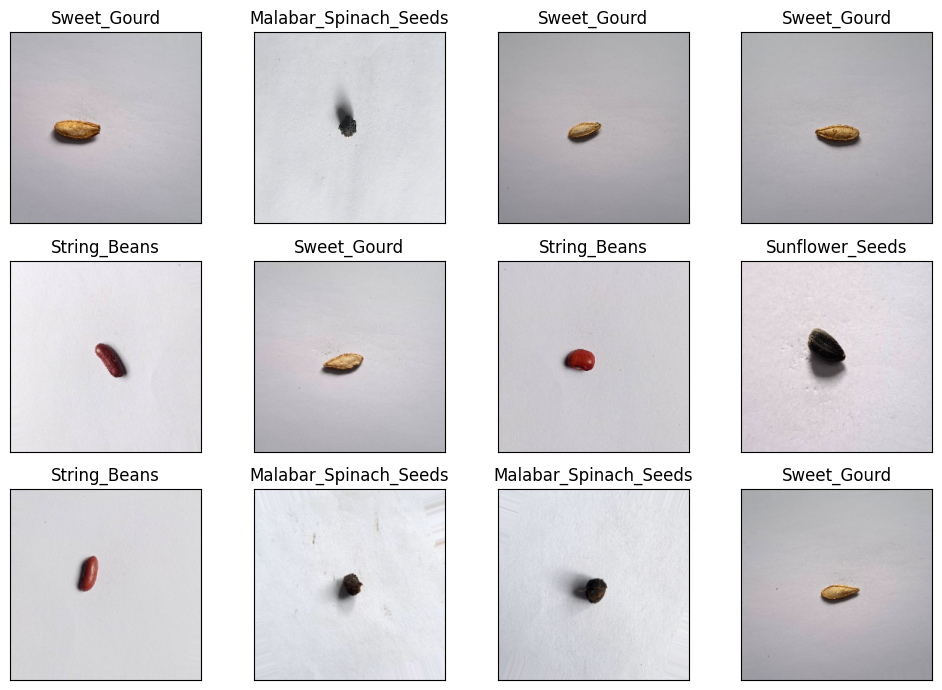

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
vc = image_df['Label'].value_counts()
print(vc)

Label
String_Beans             606
Malabar_Spinach_Seeds    520
Sweet_Gourd              500
Sunflower_Seeds          500
Bitter_Gourd             500
Bottle_Gourd             500
Okra_Seeds               300
Hyacinth_Bean            300
Name: count, dtype: int64


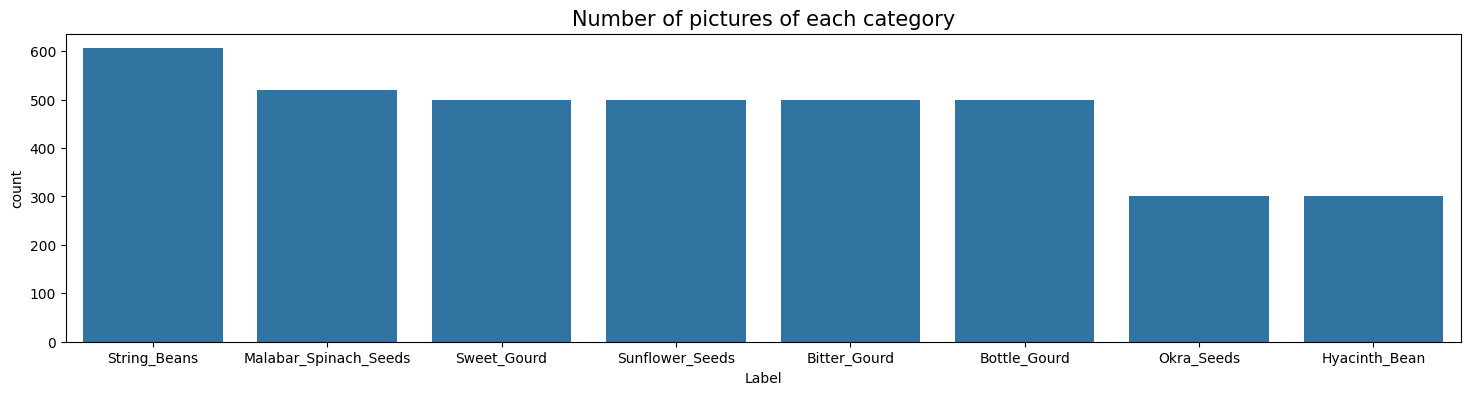

In [ ]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(18,4))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        errors='coerce' # Added to handle invalid images
    )
    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        errors='coerce' # Added to handle invalid images
    )
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        errors='coerce' # Added to handle invalid images
    )
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.60, shuffle=True, random_state=1)

In [ ]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 2235 validated image filenames belonging to 8 classes.
Found 2235 validated image filenames belonging to 8 classes.
Found 1491 validated image filenames belonging to 8 classes.


**CNN Model**

In [ ]:
input_shape = (32, 224, 224, 3)
n_classes = 8 # Changed to 8 classes to match the dataset
model_01 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  # Output layer with 8 units
])

model_01.build(input_shape=input_shape)
model_01.summary()
model_01.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 24, 24, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 12, 12, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 10, 10, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 5, 5, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 6400)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 512)              │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 8)                │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,760 (14.14 MB)

 Trainable params: 3,706,760 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_01 = model_01.fit(train_images,validation_data=val_images,epochs=20,verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 617s 9s/step - accuracy: 0.4527 - loss: 1.4246 - val_accuracy: 0.7136 - val_loss: 0.8797
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 319ms/step - accuracy: 0.8164 - loss: 0.5275 - val_accuracy: 0.9405 - val_loss: 0.1857
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.9295 - loss: 0.2092 - val_accuracy: 0.9660 - val_loss: 0.1102
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 316ms/step - accuracy: 0.9601 - loss: 0.1307 - val_accuracy: 0.9638 - val_loss: 0.0916
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 0.9747 - loss: 0.0798 - val_accuracy: 0.9723 - val_loss: 0.0891
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 308ms/step - accuracy: 0.9702 - loss: 0.1114 - val_accuracy: 0.9888 - val_loss: 0.0385
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 0.9821 - loss: 0.0482 - val_accuracy: 0.9544 - val_loss: 0.0972
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 0.9832 - loss: 0.0514 - val_accura

Train Accuracy and Loss Plot: 



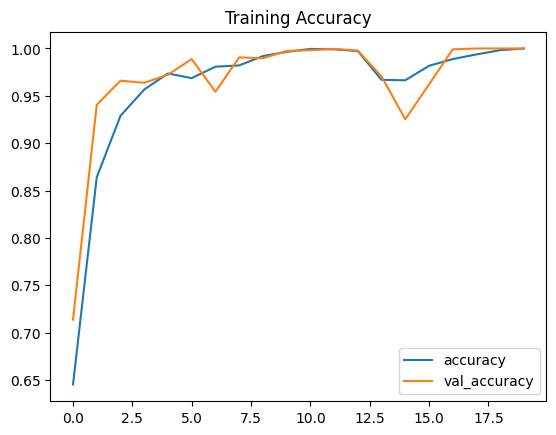

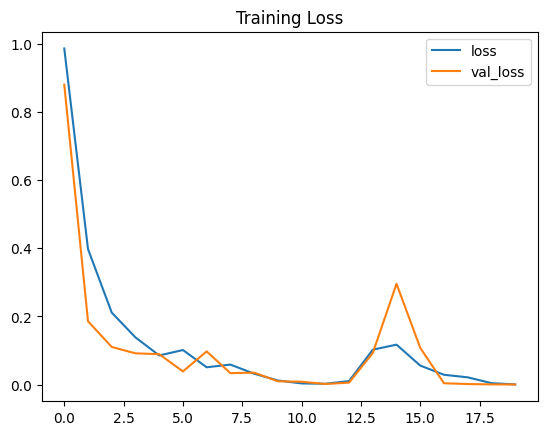



Accuracy on the test set: 99.53%
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step
Accuracy: 0.99531
Precision: 0.99533
Recall: 0.99531
F1 Score: 0.99529
                       precision    recall  f1-score   support

         Bitter_Gourd       0.99      1.00      1.00       196
         Bottle_Gourd       1.00      1.00      1.00       198
        Hyacinth_Bean       1.00      0.98      0.99       115
Malabar_Spinach_Seeds       0.98      1.00      0.99       196
           Okra_Seeds       0.99      0.97      0.98       127
         String_Beans       0.99      1.00      0.99       248
      Sunflower_Seeds       1.00      1.00      1.00       213
          Sweet_Gourd       1.00      1.00      1.00       198

             accuracy                           1.00      1491
            macro avg       1.00      0.99      0.99      1491
         weighted avg       1.00      1.00      1.00      1491

Confusion Matrix of CNN: 




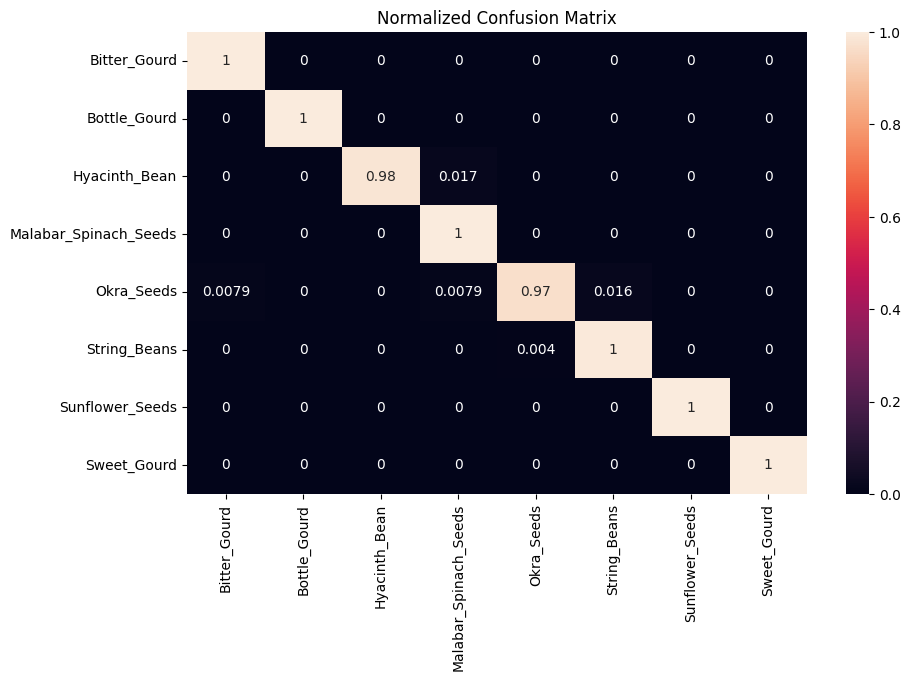

Performance: 

Rec=  99.33850468244415
Spe=  99.99955604341105
Pre=  99.34791239785889
FPR=  0.000443956588963659
FNR=  0.661495317555852
NPV=  99.99955604971818
FDR=  0.6520876021411062




In [ ]:
val_acc = history_01.history['val_accuracy']
train_acc = history_01.history['accuracy']

results = model_01.evaluate(test_images, verbose=0)
res=results[1]
test_acc = [round(res,4)]

#ploting training acc loss
print("Train Accuracy and Loss Plot: \n")
pd.DataFrame(history_01.history)[['accuracy','val_accuracy']].plot()
plt.title("Training Accuracy")
plt.show()
pd.DataFrame(history_01.history)[['loss','val_loss']].plot()
plt.title("Training Loss")
plt.show()
print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))

from sklearn.metrics import confusion_matrix
import seaborn as sns
pred = model_01.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = list(test_df.Label)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print(classification_report(y_test, pred))

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from numpy import mean
print("Confusion Matrix of CNN: \n\n")
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()
confusion_matrix=cf_matrix
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = len(y_test) - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
print("Performance: \n")
print("Rec= ",mean(TPR)*100)
print("Spe= ",mean(TNR)*100)
print("Pre= ",mean(PPV)*100)
print("FPR= ",mean(FPR)*100)
print("FNR= ",mean(FNR)*100)
print("NPV= ",mean(NPV)*100)
print("FDR= ",mean(FDR)*100)
print("\n")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step


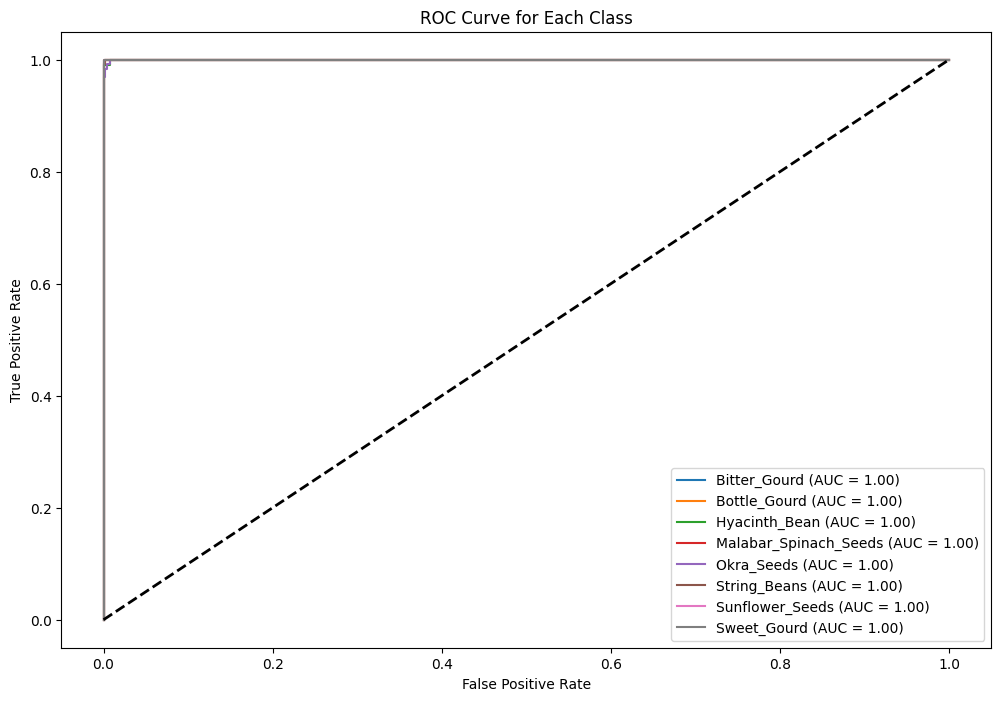

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Convert labels to binary matrix
y_test_bin = label_binarize(y_test, classes=sorted(set(y_test)))

# Predict probabilities for each class
y_score = model_01.predict(test_images)

# Get the class indices from the training data generator
class_indices = train_images.class_indices
sorted_class_names = sorted(class_indices.keys())

# Compute ROC curve and AUC for each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(sorted_class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

**CNN 2**

In [ ]:
input_shape = (224, 224, 3) # Corrected input shape
n_classes = 8 # Changed to 2

model_02 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape), # Added input_shape
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax') # Output layer with dynamic units
])

# Remove the explicit build call, as it's redundant and causing the error
# model_02.build(input_shape=input_shape)
model_02.summary()

model_02.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,682,632 (36.94 MB)

 Trainable params: 9,682,632 (36.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_02 = model_02.fit(train_images,validation_data=val_images,epochs=20,verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 362ms/step - accuracy: 0.4959 - loss: 1.4386 - val_accuracy: 0.8242 - val_loss: 0.4224
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.8702 - loss: 0.3615 - val_accuracy: 0.9584 - val_loss: 0.1428
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 318ms/step - accuracy: 0.9420 - loss: 0.1899 - val_accuracy: 0.9239 - val_loss: 0.2008
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 308ms/step - accuracy: 0.9540 - loss: 0.1306 - val_accuracy: 0.9830 - val_loss: 0.0544
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 0.9623 - loss: 0.1004 - val_accuracy: 0.9709 - val_loss: 0.0848
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 308ms/step - accuracy: 0.9669 - loss: 0.0987 - val_accuracy: 0.9897 - val_loss: 0.0257
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 0.9854 - loss: 0.0480 - val_accuracy: 0.9839 - val_loss: 0.0441
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 314ms/step - accuracy: 0.9776 - loss: 0.0651 - val_accu

In [ ]:
# Create the generators outside the function
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.60, shuffle=True, random_state=1)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



Found 2235 validated image filenames belonging to 8 classes.
Found 2235 validated image filenames belonging to 8 classes.
Found 1491 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Train Accuracy and Loss Plot: 



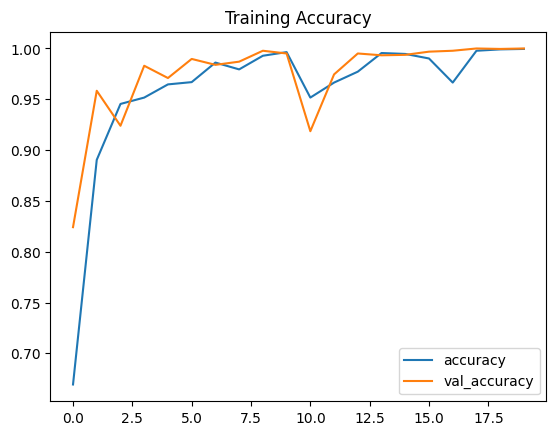

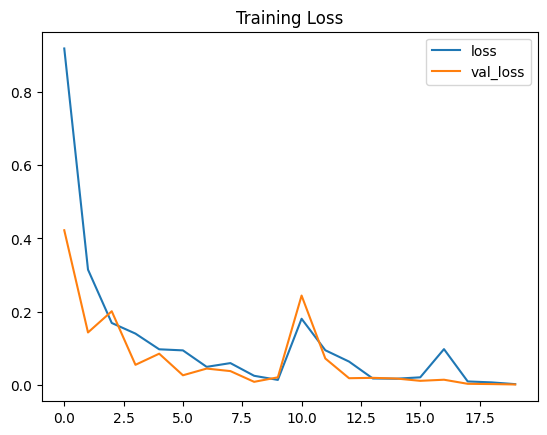



Accuracy on the test set: 98.66%
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step
Accuracy: 0.98659
Precision: 0.98669
Recall: 0.98659
F1 Score: 0.98657
                       precision    recall  f1-score   support

         Bitter_Gourd       1.00      0.98      0.99       196
         Bottle_Gourd       1.00      1.00      1.00       198
        Hyacinth_Bean       0.98      0.97      0.98       115
Malabar_Spinach_Seeds       0.98      0.96      0.97       196
           Okra_Seeds       0.98      0.98      0.98       127
         String_Beans       0.99      0.99      0.99       248
      Sunflower_Seeds       0.97      1.00      0.98       213
          Sweet_Gourd       0.99      1.00      0.99       198

             accuracy                           0.99      1491
            macro avg       0.99      0.99      0.99      1491
         weighted avg       0.99      0.99      0.99      1491

Confusion Matrix of CNN: 




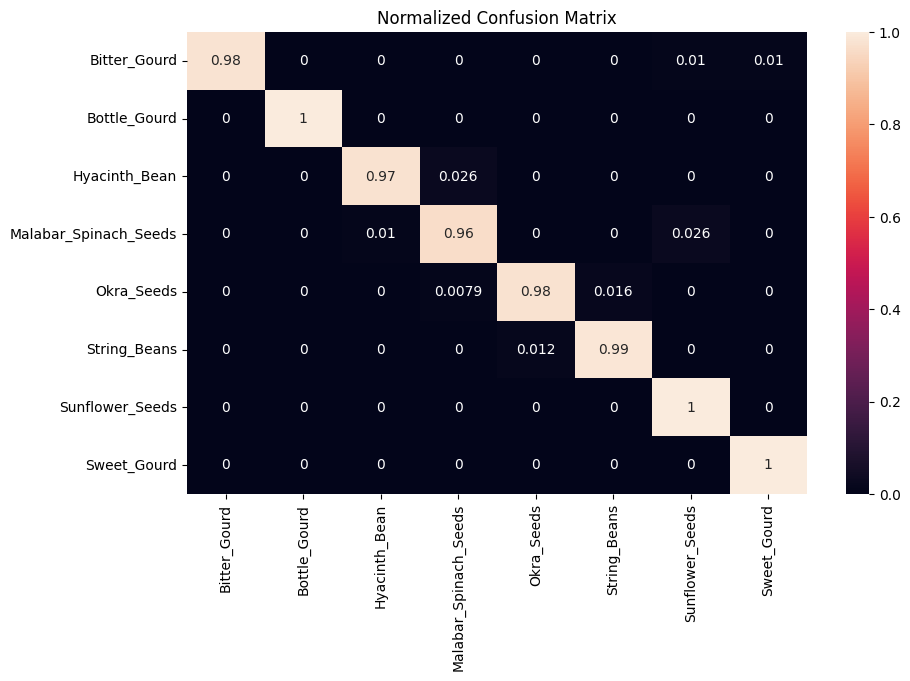

Performance: 

Rec=  98.52589716326283
Spe=  99.9990106692371
Pre=  98.53872854712529
FPR=  0.0009893307629108546
FNR=  1.474102836737172
NPV=  99.99901067555166
FDR=  1.4612714528747073




In [ ]:
val_acc = history_02.history['val_accuracy']
train_acc = history_02.history['accuracy']

results = model_02.evaluate(test_images, verbose=0)
res=results[1]
test_acc = [round(res,4)]

#ploting training acc loss
print("Train Accuracy and Loss Plot: \n")
pd.DataFrame(history_02.history)[['accuracy','val_accuracy']].plot()
plt.title("Training Accuracy")
plt.show()
pd.DataFrame(history_02.history)[['loss','val_loss']].plot()
plt.title("Training Loss")
plt.show()
print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))

from sklearn.metrics import confusion_matrix
import seaborn as sns
pred = model_02.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = list(test_df.Label)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print(classification_report(y_test, pred))

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from numpy import mean
print("Confusion Matrix of CNN: \n\n")
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()
confusion_matrix=cf_matrix
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = len(y_test) - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
print("Performance: \n")
print("Rec= ",mean(TPR)*100)
print("Spe= ",mean(TNR)*100)
print("Pre= ",mean(PPV)*100)
print("FPR= ",mean(FPR)*100)
print("FNR= ",mean(FNR)*100)
print("NPV= ",mean(NPV)*100)
print("FDR= ",mean(FDR)*100)
print("\n")

In [ ]:
# Create the generators outside the function
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.60, shuffle=True, random_state=1)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



In [ ]:
history_02 = model_02.fit(train_images,validation_data=val_images,epochs=25,verbose=1)

In [ ]:
val_acc = history_02.history['val_accuracy']
train_acc = history_02.history['accuracy']

results = model_02.evaluate(test_images, verbose=0)
res=results[1]
test_acc = [round(res,4)]

#ploting training acc loss
print("Train Accuracy and Loss Plot: \n")
pd.DataFrame(history_02.history)[['accuracy','val_accuracy']].plot()
plt.title("Training Accuracy")
plt.show()
pd.DataFrame(history_02.history)[['loss','val_loss']].plot()
plt.title("Training Loss")
plt.show()
print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))

from sklearn.metrics import confusion_matrix
import seaborn as sns
pred = model_02.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = list(test_df.Label)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print(classification_report(y_test, pred))

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from numpy import mean
print("Confusion Matrix of CNN: \n\n")
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()
confusion_matrix=cf_matrix
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = len(y_test) - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
print("Performance: \n")
print("Rec= ",mean(TPR)*100)
print("Spe= ",mean(TNR)*100)
print("Pre= ",mean(PPV)*100)
print("FPR= ",mean(FPR)*100)
print("FNR= ",mean(FNR)*100)
print("NPV= ",mean(NPV)*100)
print("FDR= ",mean(FDR)*100)
print("\n")

**Transfer Learning Models**

In [ ]:
def get_model(model):
    # Load the pretained model
    kwargs = {'input_shape':(224, 224, 3),
    'include_top':False,
    'weights':'imagenet',
    'pooling':'avg'}

    # Create the input layer
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Instantiate the pretrained model with the input tensor
    pretrained_model = model(input_tensor=inputs, **kwargs)

    pretrained_model.trainable = False
    # inputs = pretrained_model.input # This line is no longer needed as we created the input layer explicitly
    x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    # Changed the output layer to 6 units
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x) # Changed to 8 units to match the dataset
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
    return model

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.60, shuffle=True, random_state=1)
# Dictionary with the models
models = {
"DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
"MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
"VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
print('\n')


Found 2235 validated image filenames belonging to 8 classes.
Found 2235 validated image filenames belonging to 8 classes.
Found 1491 validated image filenames belonging to 8 classes.








DenseNet201 Model Training Started ===>>>


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7996 - loss: 0.6222 - val_accuracy: 0.9982 - val_loss: 0.0123
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 316ms/step - accuracy: 0.9952 - loss: 0.0165 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 326ms/step - accuracy: 0.9992 - loss: 0.0043 - val_accuracy: 0.9996 - val_loss: 0.0019
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 0.9989 - loss: 0.0043 - val_accuracy: 0.9991 - val_loss: 0.0025
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9951 - val_loss: 0.0129
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 318ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - accuracy: 0.9981 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 3.0340e-04
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 1.0000 - loss: 2.9515e-04 - va

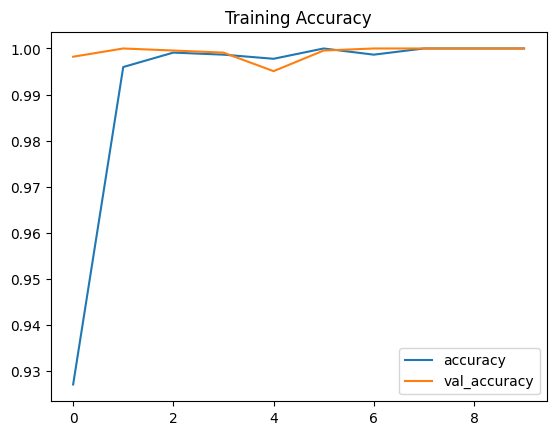

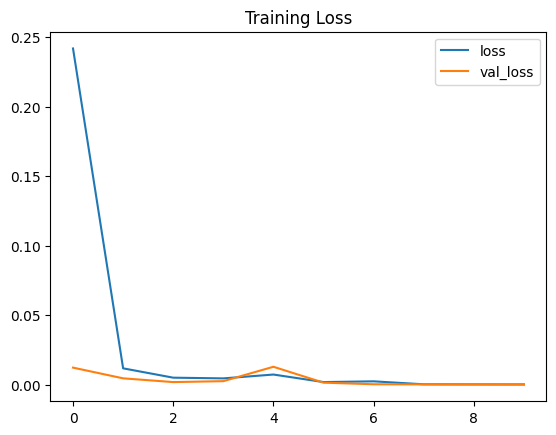



Accuracy on the test set: 99.93%
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 641ms/step
Accuracy: 0.99933
Precision: 0.99933
Recall: 0.99933
F1 Score: 0.99933
                       precision    recall  f1-score   support

         Bitter_Gourd       1.00      1.00      1.00       196
         Bottle_Gourd       1.00      1.00      1.00       198
        Hyacinth_Bean       1.00      1.00      1.00       115
Malabar_Spinach_Seeds       1.00      1.00      1.00       196
           Okra_Seeds       1.00      0.99      1.00       127
         String_Beans       1.00      1.00      1.00       248
      Sunflower_Seeds       1.00      1.00      1.00       213
          Sweet_Gourd       1.00      1.00      1.00       198

             accuracy                           1.00      1491
            macro avg       1.00      1.00      1.00      1491
         weighted avg       1.00      1.00      1.00      1491

DenseNet201 Confusion Matrix: 




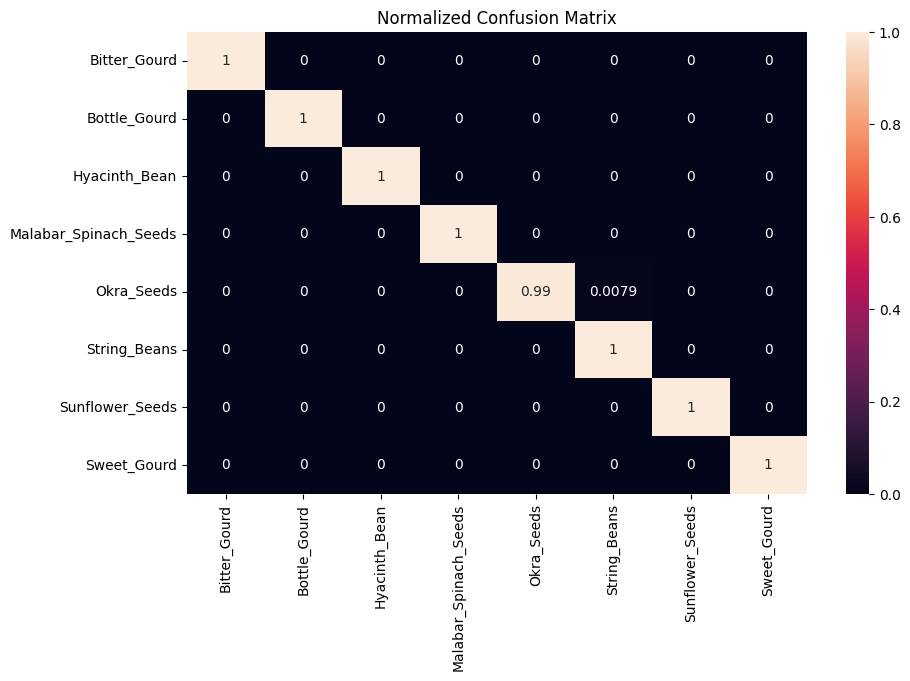

Performance: 

Rec=  99.9015748031496
Spe=  99.9999339428209
Pre=  99.90234375
FPR=  6.605717909422385e-05
FNR=  0.09842519685039353
NPV=  99.99993394316999
FDR=  0.09765624999999983




9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 Model Training Started ===>>>
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 568ms/step - accuracy: 0.8312 - loss: 0.5247 - val_accuracy: 0.9978 - val_loss: 0.0099
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 0.9965 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 6.5690e-04
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 314ms/step - accuracy: 1.0000 - loss: 9.1669e-04 - val_accuracy: 1.0000 - val_loss: 3.8374e-04
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 1.0000 - loss: 3.4363e-04 - val_accuracy: 1.0000 - val_loss: 3.2302e-04
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - ac

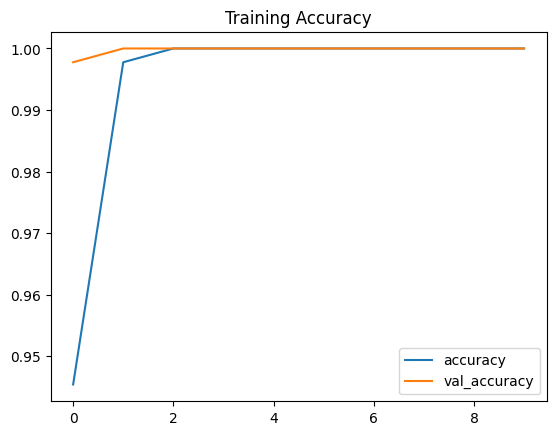

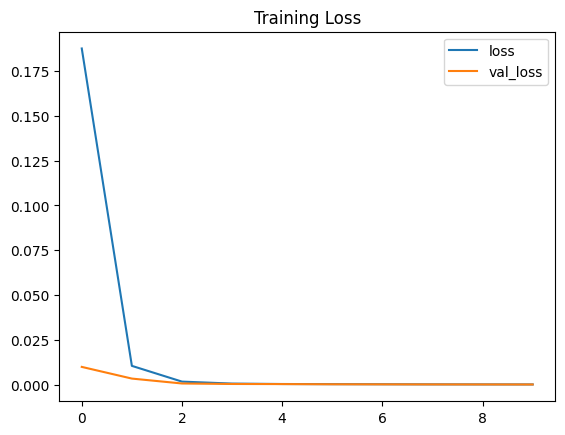



Accuracy on the test set: 99.87%
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step
Accuracy: 0.99866
Precision: 0.99867
Recall: 0.99866
F1 Score: 0.99866
                       precision    recall  f1-score   support

         Bitter_Gourd       0.99      1.00      1.00       196
         Bottle_Gourd       1.00      1.00      1.00       198
        Hyacinth_Bean       1.00      1.00      1.00       115
Malabar_Spinach_Seeds       1.00      0.99      1.00       196
           Okra_Seeds       0.99      1.00      1.00       127
         String_Beans       1.00      1.00      1.00       248
      Sunflower_Seeds       1.00      1.00      1.00       213
          Sweet_Gourd       1.00      1.00      1.00       198

             accuracy                           1.00      1491
            macro avg       1.00      1.00      1.00      1491
         weighted avg       1.00      1.00      1.00      1491

MobileNetV2 Confusion Matrix: 




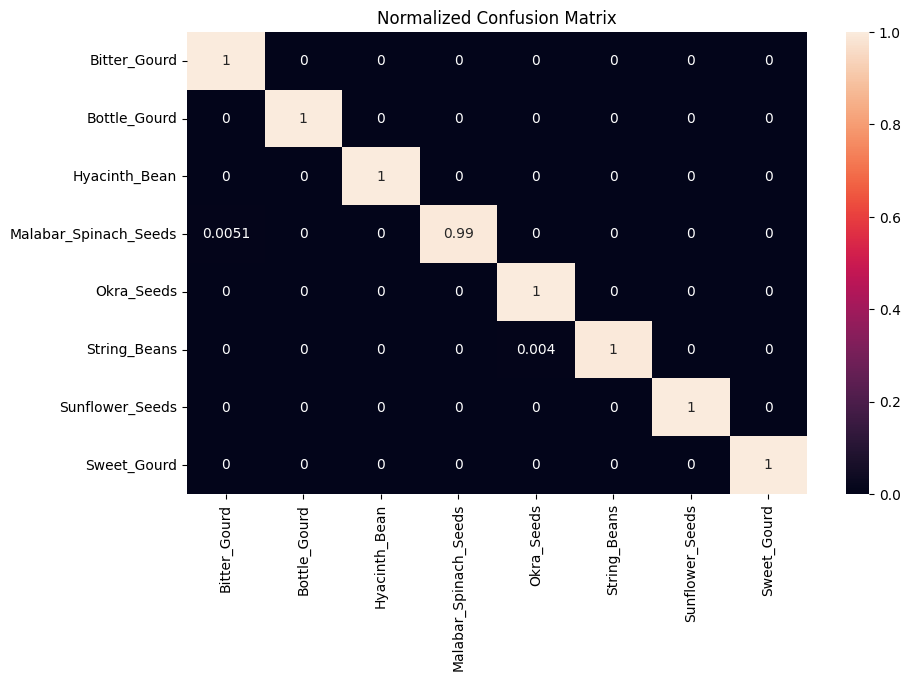

Performance: 

Rec=  99.88582126398947
Spe=  99.99992336997583
Pre=  99.8863474201374
FPR=  7.66300241681436e-05
FNR=  0.11417873601053258
NPV=  99.99992337021393
FDR=  0.11365257986259833




80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 Model Training Started ===>>>
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.2901 - loss: 1.9016 - val_accuracy: 0.6412 - val_loss: 1.0919
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 307ms/step - accuracy: 0.7639 - loss: 0.8491 - val_accuracy: 0.9320 - val_loss: 0.3784
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.9358 - loss: 0.3267 - val_accuracy: 0.9651 - val_loss: 0.1994
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 314ms/step - accuracy: 0.9581 - loss: 0.1851 - val_accuracy: 0.9790 - val_loss: 0.1152
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 0.9847 - loss: 0.1033 - val_accuracy: 0.9879 - val_loss: 0.0663
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.9875 - l

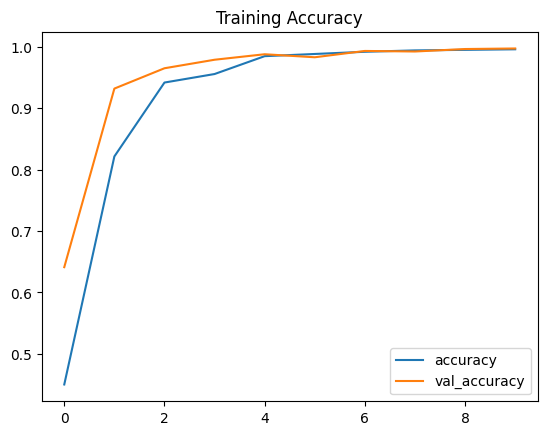

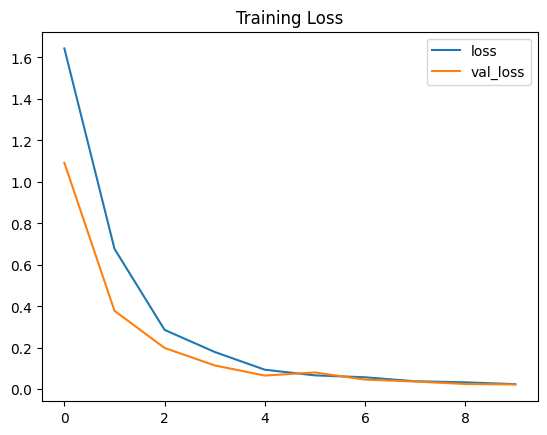



Accuracy on the test set: 99.20%
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step
Accuracy: 0.99195
Precision: 0.99204
Recall: 0.99195
F1 Score: 0.99195
                       precision    recall  f1-score   support

         Bitter_Gourd       0.99      0.99      0.99       196
         Bottle_Gourd       1.00      1.00      1.00       198
        Hyacinth_Bean       0.99      0.98      0.99       115
Malabar_Spinach_Seeds       0.98      1.00      0.99       196
           Okra_Seeds       0.99      1.00      1.00       127
         String_Beans       1.00      1.00      1.00       248
      Sunflower_Seeds       1.00      0.98      0.99       213
          Sweet_Gourd       0.98      0.99      0.99       198

             accuracy                           0.99      1491
            macro avg       0.99      0.99      0.99      1491
         weighted avg       0.99      0.99      0.99      1491

VGG19 Confusion Matrix: 




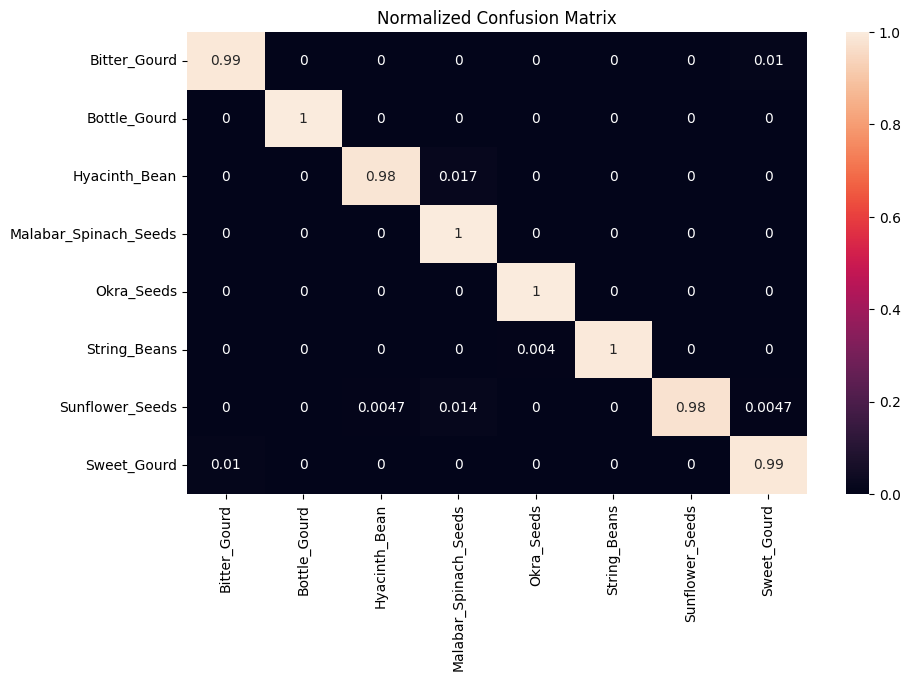

Performance: 

Rec=  99.18496459312799
Spe=  99.99945299637123
Pre=  99.19729477875399
FPR=  0.0005470036287731647
FNR=  0.8150354068720154
NPV=  99.99945300054154
FDR=  0.8027052212460205




In [ ]:
# Fit the models
for name, model in models.items():
    print('\n')
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    print(f"{name:2} Model Training Started ===>>>")
    start = perf_counter()
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=10,verbose=1)
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:2} trained in {duration} sec")
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]
    results = m.evaluate(test_images, verbose=0)
    res=results[1]
    models[name]['test_accuracy'] = [round(res,4)]
    #ploting training acc loss
    print(f"{name:2} Train Accuracy and Loss Plot: \n")
    pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
    plt.title("Training Accuracy")
    plt.show()
    pd.DataFrame(history.history)[['loss','val_loss']].plot()
    plt.title("Training Loss")
    plt.show()
    print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    pred = m.predict(test_images)
    pred = np.argmax(pred,axis=1)
    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = list(test_df.Label)
    print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
    print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
    print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
    print(classification_report(y_test, pred))
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    import math
    from numpy import mean
    print(f"{name:2} Confusion Matrix: \n\n")
    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize = (10,6))
    sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
    plt.title('Normalized Confusion Matrix')
    plt.show()
    confusion_matrix=cf_matrix
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = len(y_test) - (FP + FN + TP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    print("Performance: \n")
    print("Rec= ",mean(TPR)*100)
    print("Spe= ",mean(TNR)*100)
    print("Pre= ",mean(PPV)*100)
    print("FPR= ",mean(FPR)*100)
    print("FNR= ",mean(FNR)*100)
    print("NPV= ",mean(NPV)*100)
    print("FDR= ",mean(FDR)*100)
    print("\n")

Found 2235 validated image filenames belonging to 8 classes.
Found 2235 validated image filenames belonging to 8 classes.
Found 1491 validated image filenames belonging to 8 classes.






83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Xception Model Training Started ===>>>


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 63s 622ms/step - accuracy: 0.8253 - loss: 0.5923 - val_accuracy: 0.9669 - val_loss: 0.0817
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 318ms/step - accuracy: 0.9868 - loss: 0.0364 - val_accuracy: 0.9928 - val_loss: 0.0244
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - accuracy: 0.9956 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9991 - val_loss: 0.0021
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 6.6490e-04
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 1.0000 - loss: 3.5936e-04 - val_accuracy: 1.0000 - val_loss: 7.0751e-04
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - accuracy: 1.0000 - loss: 4.1248e-04 - val_accuracy: 1.0000 - val_loss: 2.6313e-04
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 1.0000 - los

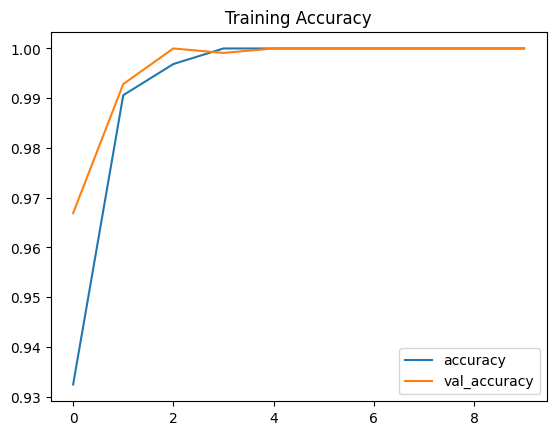

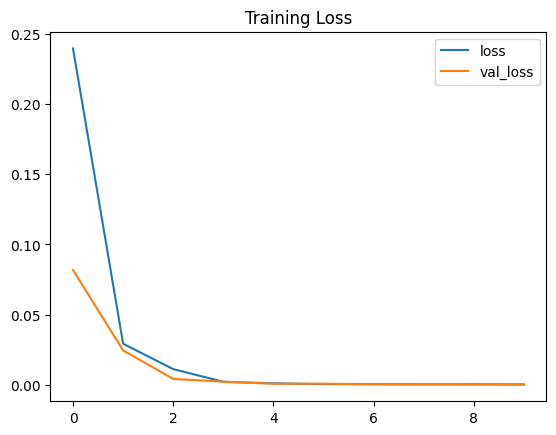



Accuracy on the test set: 99.80%
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step
Accuracy: 0.998
Precision: 0.998
Recall: 0.998
F1 Score: 0.998
                       precision    recall  f1-score   support

         Bitter_Gourd       0.99      1.00      1.00       196
         Bottle_Gourd       1.00      0.99      1.00       198
        Hyacinth_Bean       1.00      1.00      1.00       115
Malabar_Spinach_Seeds       1.00      1.00      1.00       196
           Okra_Seeds       1.00      0.98      0.99       127
         String_Beans       0.99      1.00      1.00       248
      Sunflower_Seeds       1.00      1.00      1.00       213
          Sweet_Gourd       1.00      1.00      1.00       198

             accuracy                           1.00      1491
            macro avg       1.00      1.00      1.00      1491
         weighted avg       1.00      1.00      1.00      1491

Xception Confusion Matrix: 




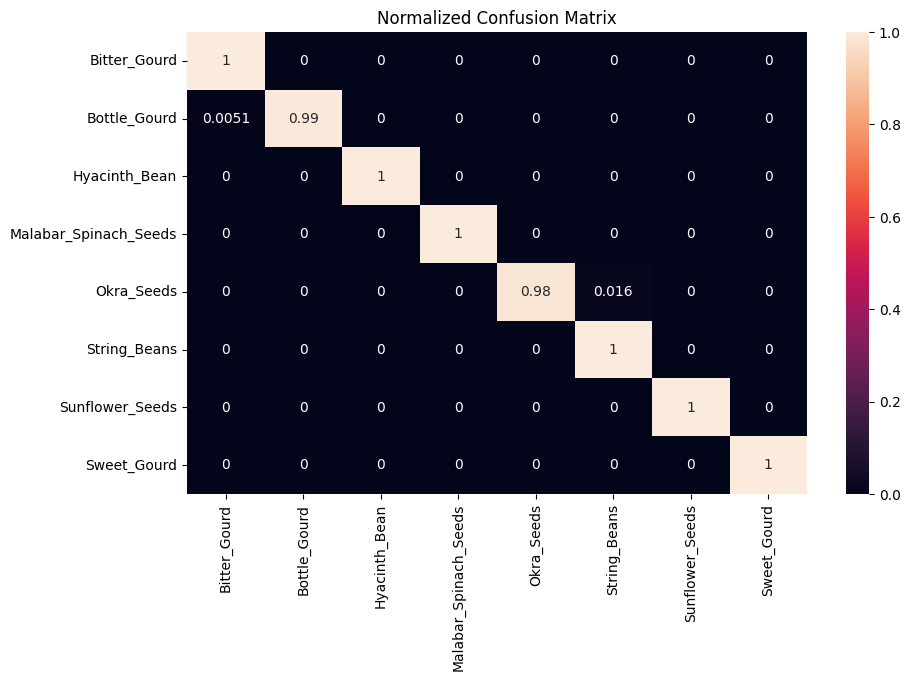

Performance: 

Rec=  99.74001829316789
Spe=  99.999825515633
Pre=  99.74338748003584
FPR=  0.00017448436700140884
FNR=  0.2599817068321006
NPV=  99.99982551717294
FDR=  0.25661251996416057




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 Model Training Started ===>>>
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 45s 481ms/step - accuracy: 0.2006 - loss: 2.0096 - val_accuracy: 0.3785 - val_loss: 1.5615
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.4877 - loss: 1.3969 - val_accuracy: 0.6998 - val_loss: 0.9541
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.7011 - loss: 0.8835 - val_accuracy: 0.7548 - val_loss: 0.7041
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 0.7659 - loss: 0.6818 - val_accuracy: 0.7785 - val_loss: 0.6215
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 0.7830 - loss: 0.5764 - val_accuracy: 0.8224 - val_loss: 0.5070
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 0.8193 

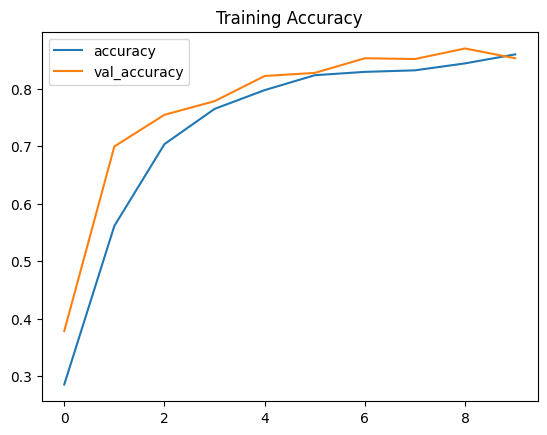

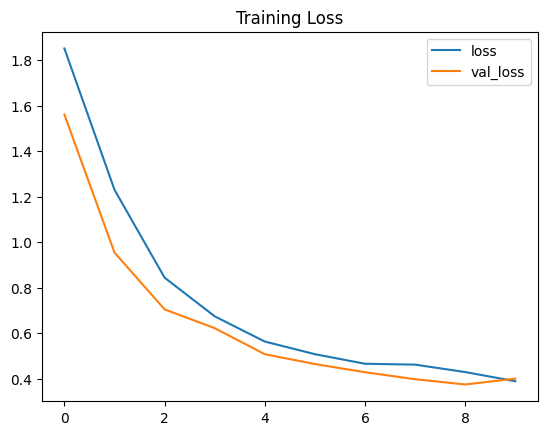



Accuracy on the test set: 82.63%
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step
Accuracy: 0.826
Precision: 0.848
Recall: 0.826
F1 Score: 0.827
                       precision    recall  f1-score   support

         Bitter_Gourd       0.75      0.72      0.73       196
         Bottle_Gourd       0.89      0.97      0.93       198
        Hyacinth_Bean       0.98      0.93      0.96       115
Malabar_Spinach_Seeds       0.62      0.96      0.75       196
           Okra_Seeds       0.88      0.84      0.86       127
         String_Beans       0.94      0.69      0.80       248
      Sunflower_Seeds       0.87      0.68      0.76       213
          Sweet_Gourd       0.89      0.90      0.90       198

             accuracy                           0.83      1491
            macro avg       0.85      0.84      0.84      1491
         weighted avg       0.85      0.83      0.83      1491

ResNet50 Confusion Matrix: 




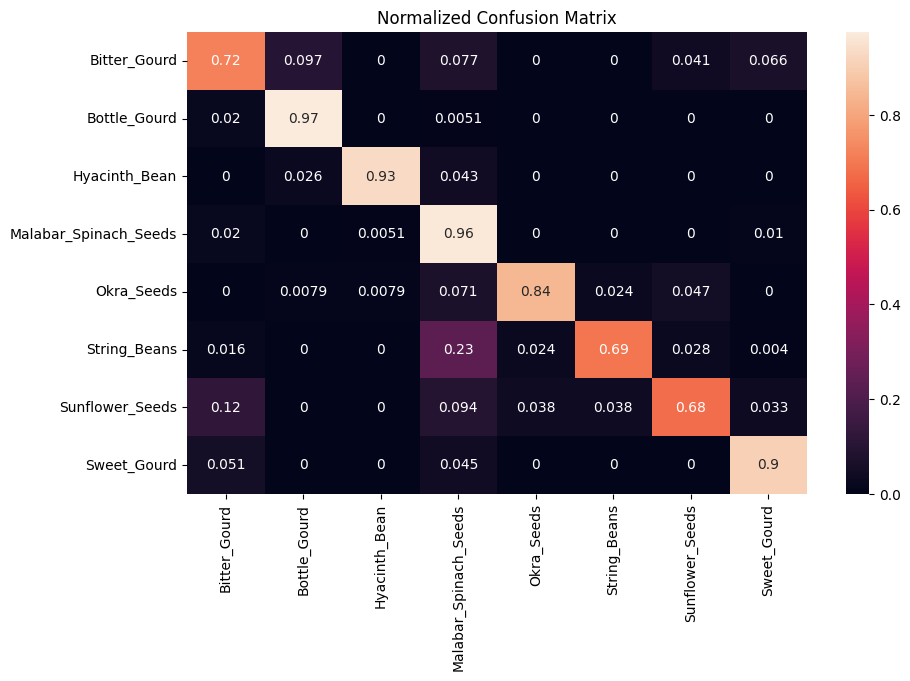

Performance: 

Rec=  83.81275676185804
Spe=  99.98913607836366
Pre=  85.59236997672622
FPR=  0.010863921636336888
FNR=  16.187243238141964
NPV=  99.98913693651954
FDR=  14.407630023273773




In [ ]:
models = {
    "Xception": {"model":tf.keras.applications.Xception, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
print('\n')

# Fit the models
for name, model in models.items():
  print('\n')

  # Get the model
  m = get_model(model['model'])
  models[name]['model'] = m

  print(f"{name:2} Model Training Started ===>>>")

  start = perf_counter()

  # Fit the model
  history = m.fit(train_images,validation_data=val_images,epochs=10,verbose=1)

  # Sav the duration, the train_accuracy and the val_accuracy
  duration = perf_counter() - start
  duration = round(duration,2)
  models[name]['perf'] = duration
  print(f"{name:2} trained in {duration} sec")

  val_acc = history.history['val_accuracy']
  models[name]['val_acc'] = [round(v,4) for v in val_acc]

  train_acc = history.history['accuracy']
  models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

  results = m.evaluate(test_images, verbose=0)
  res=results[1]
  models[name]['test_accuracy'] = [round(res,4)]

  #ploting training acc loss
  print(f"{name:2} Train Accuracy and Loss Plot: \n")

  pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
  plt.title("Training Accuracy")
  plt.show()
  pd.DataFrame(history.history)[['loss','val_loss']].plot()
  plt.title("Training Loss")
  plt.show()

  print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))

  from sklearn.metrics import confusion_matrix
  import seaborn as sns

  pred = m.predict(test_images)
  pred = np.argmax(pred,axis=1)

  # Map the label
  labels = (train_images.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  pred = [labels[k] for k in pred]
  y_test = list(test_df.Label)

  print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),3))
  print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),3))
  print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),3))
  print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),3))
  print(classification_report(y_test, pred))

  from sklearn.metrics import mean_absolute_error
  from sklearn.metrics import mean_squared_error
  import math
  from numpy import mean

  print(f"{name:2} Confusion Matrix: \n\n")
  cf_matrix = confusion_matrix(y_test, pred, normalize='true')
  plt.figure(figsize = (10,6))
  sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
  plt.title('Normalized Confusion Matrix')
  plt.show()

  confusion_matrix=cf_matrix

  FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
  FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
  TP = np.diag(confusion_matrix)
  TN = len(y_test) - (FP + FN + TP)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP)
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  print("Performance: \n")
  print("Rec= ",mean(TPR)*100)
  print("Spe= ",mean(TNR)*100)
  print("Pre= ",mean(PPV)*100)
  print("FPR= ",mean(FPR)*100)
  print("FNR= ",mean(FNR)*100)
  print("NPV= ",mean(NPV)*100)
  print("FDR= ",mean(FDR)*100)
  print("\n")

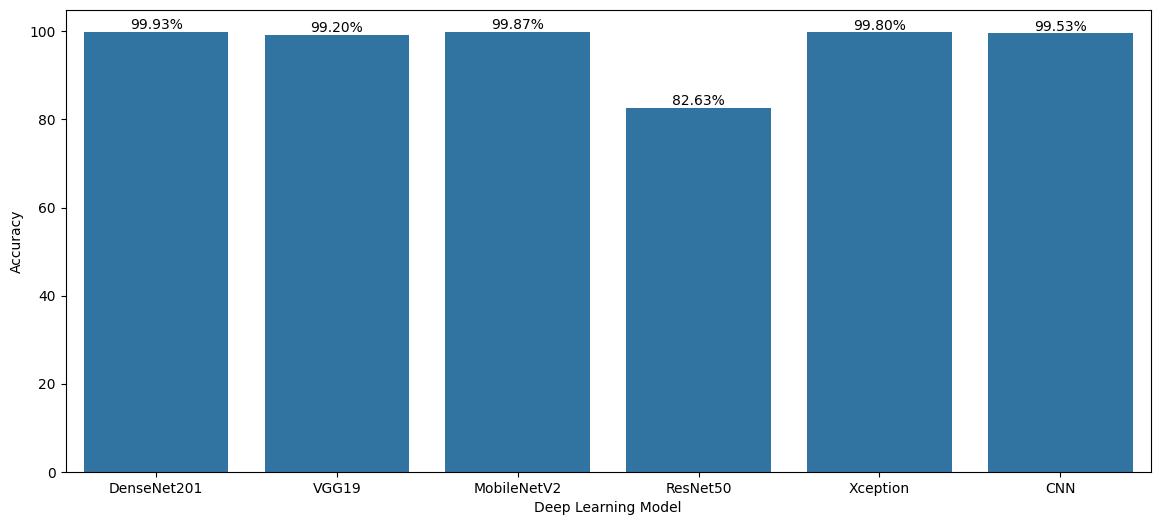

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data=
{'Deep Learning Model':['DenseNet201', 'VGG19', 'MobileNetV2', 'ResNet50' , 'Xception', 'CNN'],
'Accuracy':[99.93, 99.20, 99.87, 82.63, 99.80,99.53 ]})

plt.figure(figsize=(14,6))

p = sns.barplot(x='Deep Learning Model', y='Accuracy',data=df)
for i in p.containers:
  labels = [f'{v.get_height():0.02f}%' for v in i]
  p.bar_label(i, labels=labels)

/tmp/ipython-input-995431939.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x='Deep Learning Model', y='Accuracy', data=df, palette=colors)


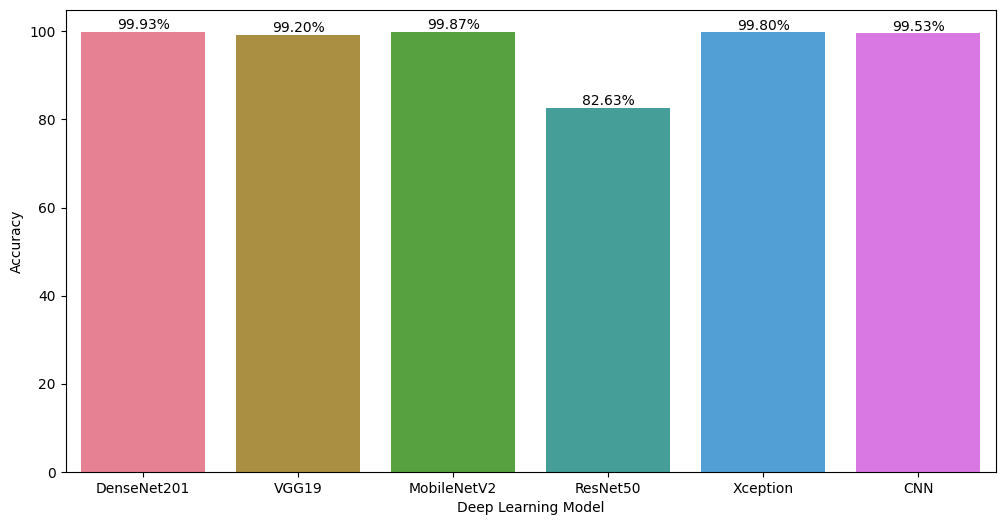

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Correct the data
df = pd.DataFrame(data={
'Deep Learning Model': ['DenseNet201', 'VGG19', 'MobileNetV2', 'ResNet50', 'Xception', 'CNN'],
'Accuracy': [99.93, 99.20, 99.87, 82.63, 99.80,99.53]
})

# Define colors for each bar
colors = sns.color_palette("husl", len(df))

plt.figure(figsize=(12, 6))

# Create the bar plot with specific colors
p = sns.barplot(x='Deep Learning Model', y='Accuracy', data=df, palette=colors)

# Adding the labels
for container in p.containers:
  p.bar_label(container, labels=[f'{v.get_height():.2f}%' for v in container])

plt.show()